# 2. Chebyshev Spectral Grid

In [109]:
import numpy as np
from scipy.special import erf
from numpy import pi, abs, max, sqrt, cos, arccos, sin, tan, exp

from numpy.linalg import inv
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt

In [2]:
N = 16 # Here n can be either even or odd

row = np.arange(N + 1)[:, None]
col = np.arange(N + 1)[None, :]

angular_spectral_grid = pi * row / N
spectral_grid         = cos(angular_spectral_grid)
angular_dense_grid    = np.linspace(0, pi, 1000)[:, None]
dense_grid            = cos(angular_dense_grid)

spectral_basis = cos(col * angular_spectral_grid)
dense_basis    = cos(col * angular_dense_grid)

## 2.1 Chebyshev polynomials and the Nyquist frequency

Some text here

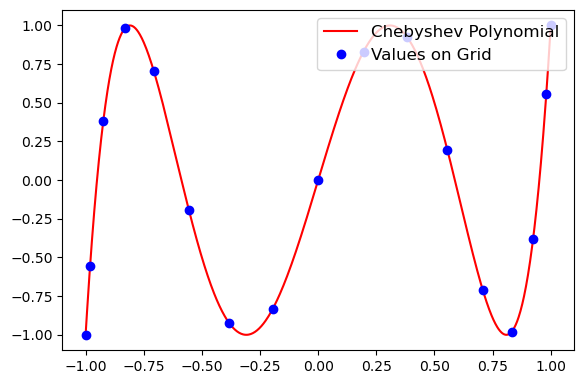

In [3]:
n = 5   # Try the Nyquist frequency n = N

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid,    dense_basis[:, n], 'r-', label = 'Chebyshev Polynomial')
ax.plot(spectral_grid, spectral_basis[:, n], 'bo',  label = 'Values on Grid')
ax.legend(loc = 'upper right')
ax.set_ylim(-1.1, 1.1)

plt.tight_layout()
################################################################################

## 2.2  The cardinal polynomials

True


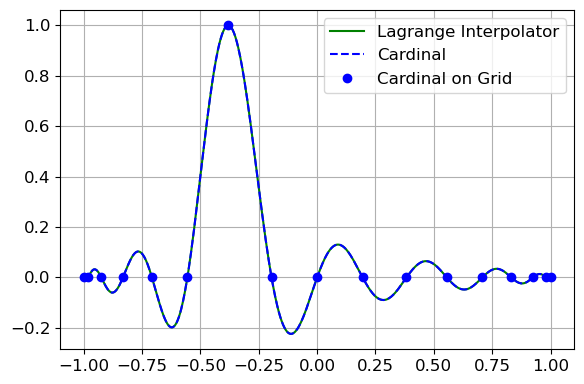

In [58]:
n = 10

def is_the_same(A, B):
    return max(abs(A - B)) < 1e-6

def LagrangeInterpolator(x, j, spectral_grid):
    numerator = (x- spectral_grid[:, None])
    numerator[j, :] = 1
    denominator = (spectral_grid[j] - spectral_grid)
    denominator[j] = 1
    return np.prod(numerator, axis = 0) / np.prod(denominator)

spectral_basis_inv = inv(spectral_basis)
spectral_cardinals = np.eye(N + 1)
dense_cardinals    = dense_basis @ spectral_basis_inv

print(is_the_same(LagrangeInterpolator(dense_grid, n, spectral_grid), dense_cardinals[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid, LagrangeInterpolator(dense_grid, n, spectral_grid), color = 'green', label = 'Lagrange Interpolator')
ax.plot(dense_grid,    dense_cardinals[:, n], 'b--', label = 'Cardinal')
ax.plot(spectral_grid, spectral_cardinals[:, n], 'bo', label = 'Cardinal on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

True


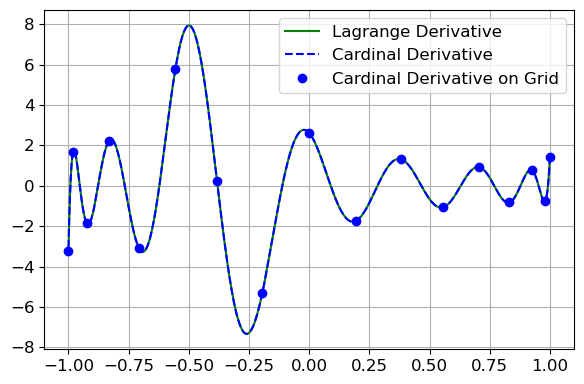

In [59]:
n = 10

def LagrangeDerivative(x, j, spectral_grid):
    epsilon = 1e-15
    numerator = (x + epsilon - spectral_grid[:, None])
    numerator[j, :] = 1
    denominator = (spectral_grid[j] - spectral_grid)
    denominator[j] = 1
    return np.prod(numerator, axis = 0) * (np.sum(1/numerator, axis = 0) - 1) / np.prod(denominator)

spectral_basis_diff = col * sin(col * angular_spectral_grid[1:-1]) / sqrt( 1 - cos(angular_spectral_grid[1:-1])**2 )
dense_basis_diff    = col * sin(col * angular_dense_grid[1:-1]) / sqrt( 1 - cos(angular_dense_grid[1:-1])**2 )
spectral_basis_diff = np.concatenate([col**2, spectral_basis_diff, - (-1)**col * col**2], axis = 0)
dense_basis_diff    = np.concatenate([col**2, dense_basis_diff   , - (-1)**col * col**2], axis = 0)

diff_matrix          = spectral_basis_diff @ spectral_basis_inv
dense_cardinals_diff = dense_basis_diff @ spectral_basis_inv

print(is_the_same(LagrangeDerivative(dense_grid, n, spectral_grid), dense_cardinals_diff[:, [n]]))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid, LagrangeDerivative(dense_grid, n, spectral_grid), color = 'green', label = 'Lagrange Derivative')
ax.plot(dense_grid, dense_cardinals_diff[:, n].real, 'b--', label = 'Cardinal Derivative')
ax.plot(spectral_grid, diff_matrix[:, n].real, 'bo',   label = 'Cardinal Derivative on Grid')
ax.legend(loc = 'upper right')
ax.grid()

plt.tight_layout()
################################################################################

## 2.3 Chebyshev Differentiation Matrices and Interpolation

In [60]:
def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x = np.cos(np.pi * row / N)
    c = ((1 + (col % N == 0)) * (-1) ** col).T
    X = np.ones(N + 1) * x
    dX = X - X.T
    D = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D = D - np.diag(np.sum(D, axis=1))
    return x, D

x, D = ChebyshevD(N)
is_the_same(D, diff_matrix)

True

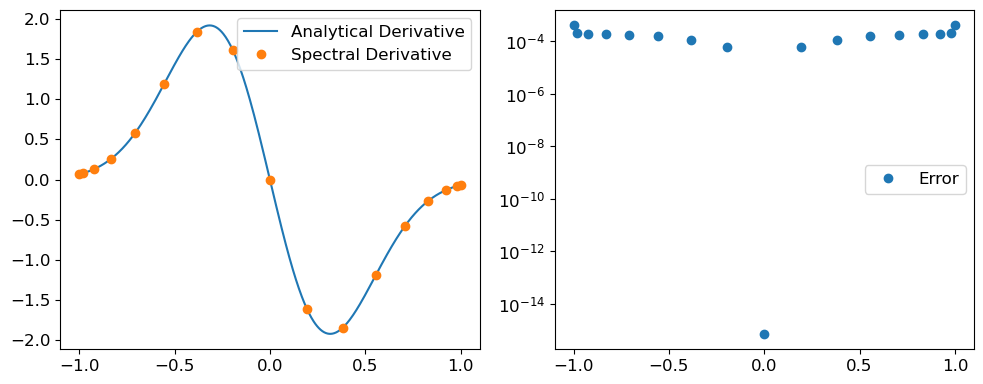

In [61]:
f  = exp( -5 * x**2 )
df = -10 * x * exp( -5 * x**2 )

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals @ df, label = 'Analytical Derivative')
ax[0].plot(x, D @ f, 'o', label = 'Spectral Derivative')
ax[0].legend(loc = 'upper right')

ax[1].set_yscale('log')
ax[1].plot(x, abs(D @ f - df), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 2.4 Chebyshev FFT Differentiation


The frequencies we are considering are: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15   0 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1].
Notice we have removed the asymetric Nyquist mode.



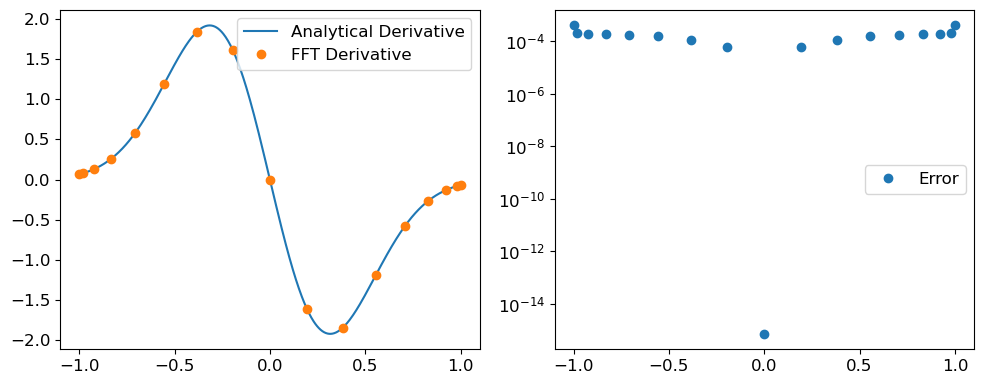

In [62]:
f  = exp( -5 * x**2 )
df = -10 * x * exp( -5 * x**2 )

def aliased_index(k, N):
    return k - N * (k >= (N + 1)//2)

freqs    = aliased_index(np.arange(2 * N), 2 * N) 
freqs[N] = 0    #This is equivalent to Trefethen's trick in page 78.

long_f    = np.concatenate([f, f[-2:0:-1, :]])
long_fft  = fft(long_f.flatten()).real 
long_ifft = ifft(1j * freqs * long_fft).real

FFT_df      = np.zeros(N + 1)
ind         = np.arange(N)
FFT_df[1:N] = - long_ifft[1:N] / sqrt(1 - x[1:-1, 0].flatten()**2)
FFT_df[0]   = np.sum(ind**2 * long_fft[:N]) / N + 0.5 * N * long_fft[N]
FFT_df[N]   = np.sum((-1)**(ind + 1) * ind**2 * long_fft[:N]) / N + 0.5 * (-1)**(N+1) * N * long_fft[N]
    
print(f'\nThe frequencies we are considering are: {freqs}.')
print(f'Notice we have removed the asymetric Nyquist mode.\n')

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ df, label = 'Analytical Derivative')
ax[0].plot(x, FFT_df, 'o', label = 'FFT Derivative')
ax[0].legend(loc = 'upper right')

ax[1].set_yscale('log')
ax[1].plot(x, abs(FFT_df - df.flatten()), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################

## 2.5 The Clenshaw-Curtis quadrature and integration

In [63]:
c      = N * (1 + (row % N == 0))
fft_an = long_fft[:N+1, None] / c

is_the_same(fft_an, spectral_basis_inv @ f)

True

In [65]:
CorrectIntegral        = 0.79142461922102708410
ClenshawCurtisIntegral = np.sum(2 * fft_an[::2] / (1 - row[::2]**2))

is_the_same(CorrectIntegral, ClenshawCurtisIntegral)

True

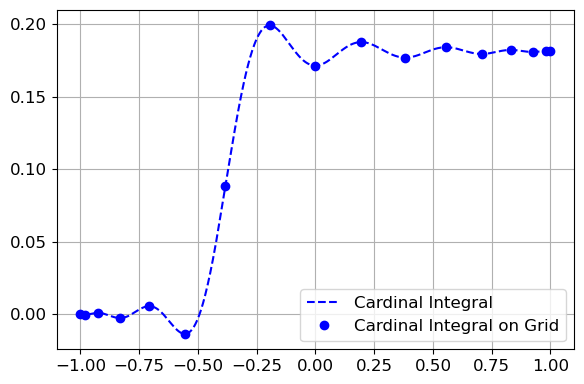

In [119]:
n = 10

scol = col[:, 2:]

spectral_basis_int  = scol * cos((scol + 1) * angular_spectral_grid) / (scol**2 - 1) - \
                      cos(angular_spectral_grid) * cos(scol * angular_spectral_grid) / (scol - 1)
spectral_basis_int  = np.concatenate([spectral_grid, spectral_grid**2 / 2, spectral_basis_int], axis = 1)
spectral_basis_int -= spectral_basis_int[[-1], :]

dense_basis_int  = scol * cos((scol + 1) * angular_dense_grid) / (scol**2 - 1) - \
                   cos(angular_dense_grid) * cos(scol * angular_dense_grid) / (scol - 1)
dense_basis_int  = np.concatenate([dense_grid, dense_grid**2 / 2, dense_basis_int], axis = 1)
dense_basis_int -= dense_basis_int[[-1], :]

int_matrix          = spectral_basis_int @ spectral_basis_inv
dense_cardinals_int = dense_basis_int @ spectral_basis_inv

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(dense_grid, dense_cardinals_int[:, n].real, 'b--', label = 'Cardinal Integral')
ax.plot(spectral_grid, int_matrix[:, n].real, 'bo', label = 'Cardinal Integral on Grid')
ax.legend(loc = 'lower right')
ax.grid()

plt.tight_layout()
################################################################################

True


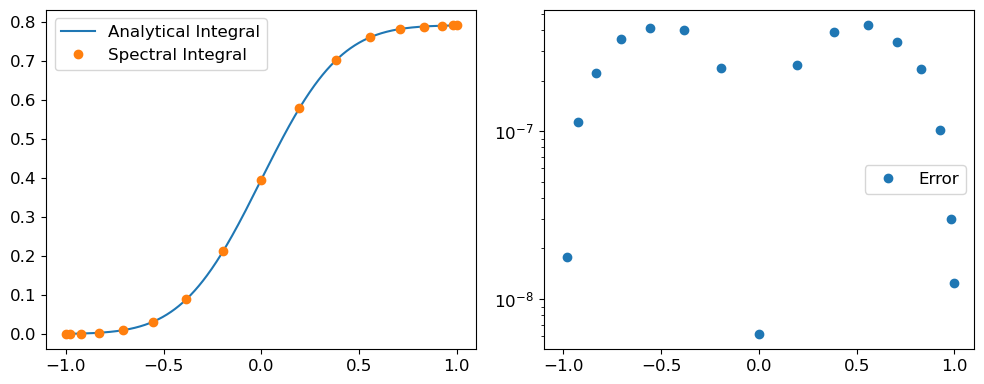

In [118]:
f  = exp( -5 * x**2 )
int_f  = 0.5 * sqrt(pi / 5) * erf(sqrt(5) * x)
int_f -= int_f[-1]

print(is_the_same(int_f[0], CorrectIntegral))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(dense_grid, dense_cardinals.real @ int_f, label = 'Analytical Integral')
ax[0].plot(x, int_matrix @ f, 'o', label = 'Spectral Integral')
ax[0].legend(loc = 'upper left')

ax[1].set_yscale('log')
ax[1].plot(x, abs(int_matrix @ f - int_f), 'o', label = 'Error')
ax[1].legend(loc = 'center right')

plt.tight_layout()
################################################################################